**Exercise and Lab: Pulse Shape Discrimination**

The goal of this exercise is to perform a pulse shape analysis on real data.

A scintillation detector is exposed to both neutron and gamma radiation, both emitted from a source places some half meter away from the detector. A detected particle (neutron or gamma) will result in an electrical pulse (a short signal) from the detector. However, the pulse shape of the detector signal depends looks different for both types of particles.

Together with the detector pulse, the flight time of the particle from the source to the detector is measured. (More on this in the introductory video for the lab.) Since gammas move at speed of light and neutrons don't, the flight times provide a second way of discriminating between neutrons and gammas, independent of the pulse shapes. Use this information to label the data.

We start by downloading a data file. For testing there is a small data set, once everything works, there is more data...

In [ ]:
# load data
# The code snippet below is responsible for downloading the dataset
# - for example when running via Google Colab.
# It is enough to load one of the files below.

# Small data file.
import os
if not os.path.exists("data_small.npy"):
  !gdown https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA

# The small data file is enough to do this exercise but if you want you can also use much more data.
# Large data file. Uncomment this line only if you really want to use all data.
# !gdown https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ

The next step will be do load the data into a numpy array and check it, e.g. by looking at some pulses.

The data consists of a (high) number of lines, each line representing one pulse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data_raw = np.load('data_small.npy')

# Check the size of the data file
print(data_raw.shape)
# Print the first pulse
# print(data[0])

(55686, 514)


The first number in each line is a detector identifier, which we can happily ignore here.

The second number is the flight time in nanoseconds, this provides information about the particle type, neutron or gamma.

The pulse is sampled at a rate of 1 GHz, so the remaining 512 numbers represent 512 ns of the pulse shape.

(55686, 512)


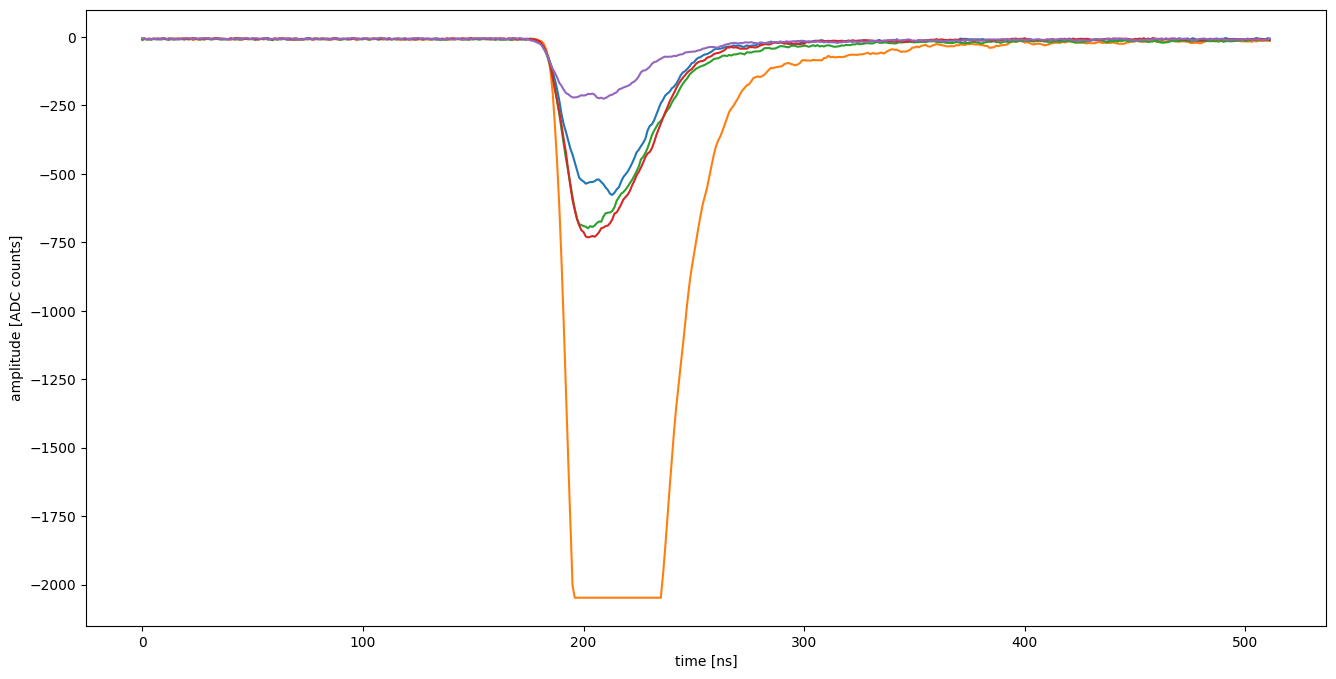

In [2]:
# Select only the pulse shape part of the data
pulses = data_raw[:,2:]
# Prepare a figure and plot some pulses
print(pulses.shape)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(pulses[0])
ax.plot(pulses[10])
ax.plot(pulses[100])
ax.plot(pulses[1000])
ax.plot(pulses[10000])
ax.set_xlabel("time [ns]")
ax.set_ylabel("amplitude [ADC counts]")
plt.show()

We will now extract the flight times.

In [3]:
times = data_raw[:,1]
print('Flight times between', times.min(), 'and', times.max(), 'nanoseconds.')

Flight times between -371.822 and 287.852 nanoseconds.


Negative flight times (also called times of flight, tof) are okay (for random coincidences), but we will restrict their range before plotting:

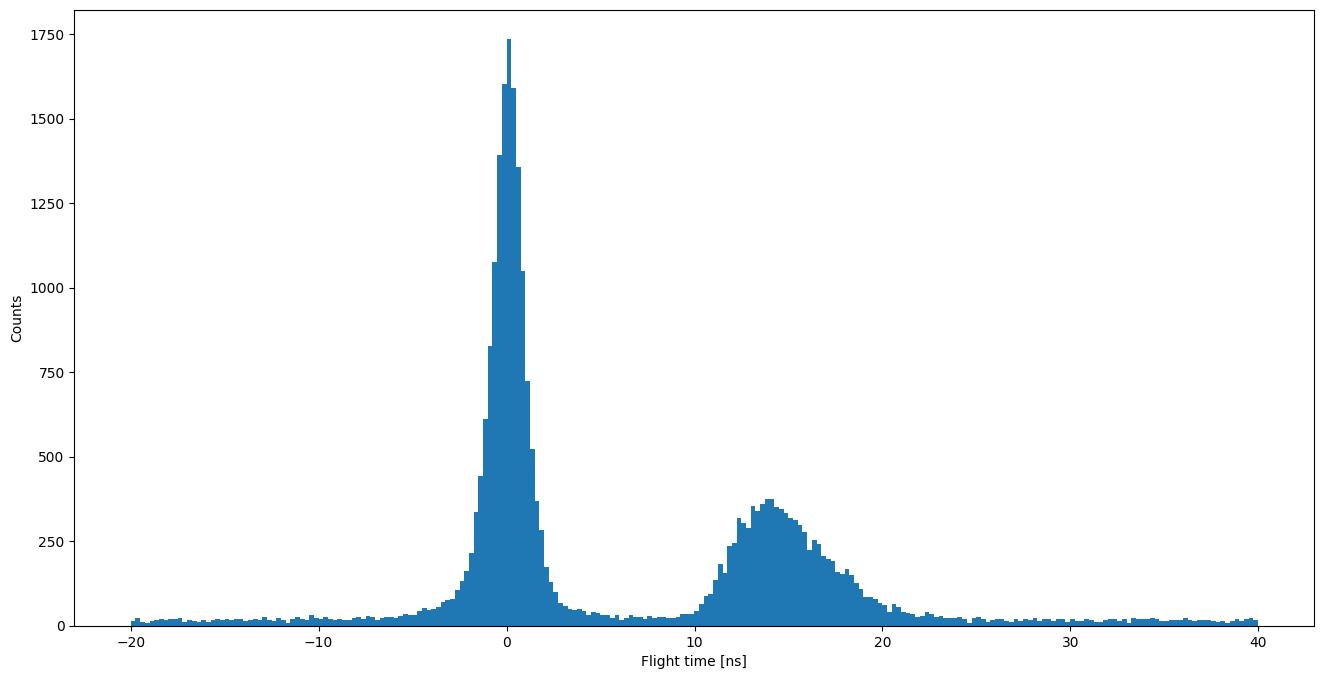

In [4]:
min_tof = -20
max_tof = 40
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')
plt.show()

The flight time spectrum shows a gamma peak at around 0 ns and a neutron peak at around 10 to 20 ns.
You can now define flight time ranges within which you will accept gammas and neutrons. Please adjust the numbers below according to your data and your liking.
During the exercise class, we will discuss how the choice of the limits affects your results.

In [5]:
gamma_min_tof = -5 # start slightly before the gamma peak
gamma_max_tof = 5 # end slightly after the gamma peak to capture the full gamma distribution
neutron_min_tof = 10
neutron_max_tof = 20

gammadata = data_raw[(data_raw[:,1] >= gamma_min_tof) & (data_raw[:,1] <= gamma_max_tof)]
gammapulses = gammadata[:,2:]
print('Gammas:  ', gammapulses.shape)

neutrondata = data_raw[(data_raw[:,1] >= neutron_min_tof) & (data_raw[:,1] <= neutron_max_tof)]
neutronpulses = neutrondata[:,2:]
print('Neutrons:', neutronpulses.shape)



Gammas:   (15870, 512)
Neutrons: (8690, 512)


You now have two arrays with pulse shapes, one with only gammas (according to the flight times) and one with only neutrons (again, according to the flight times). Each array contains a large number of pulse shapes, each pulse consists of 512 detector readings.

Let's start preparing the data for the training of a neural network.



In [6]:
# make a combined data set containing both pulse types
data = np.vstack((gammapulses, neutronpulses))
labels = np.zeros(len(data), dtype=int)
labels[:len(gammapulses)] = 1
# gammas are labelled as 1, and neutrons are labelled as 0

# normalize the data
data = data / np.max(np.abs(data), axis=1, keepdims=True)


samples_per_pulse = len(data[0])

# in case you use a CNN architecture, we need to add an empty axis.
data = data[:,:, np.newaxis]

# before we split up the dataset into training, validation and test data set, we need to shuffle the events
# otherwise we end up having only one type of event in our validation and test data sets.
np.random.seed(1234)
shuffle_indices = np.arange(0, len(data), dtype=int)
np.random.shuffle(shuffle_indices)
data = data[shuffle_indices]
labels = labels[shuffle_indices]

from sklearn.model_selection import train_test_split

# Split data into 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


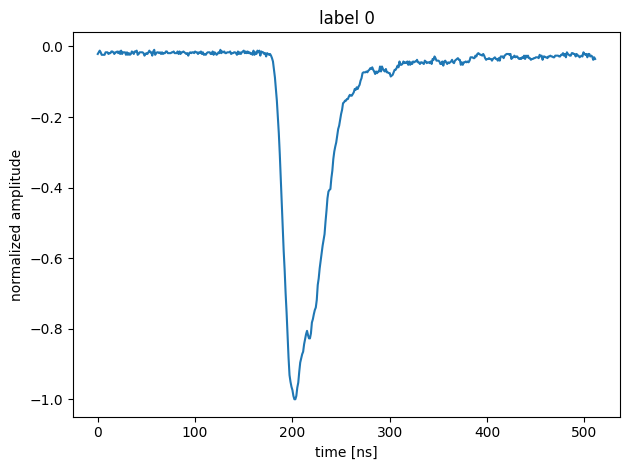

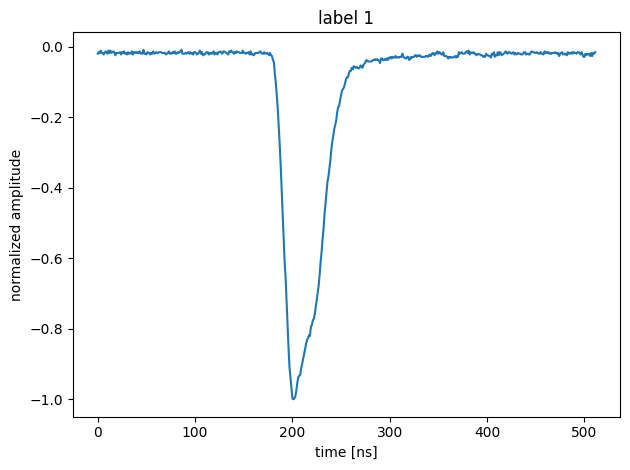

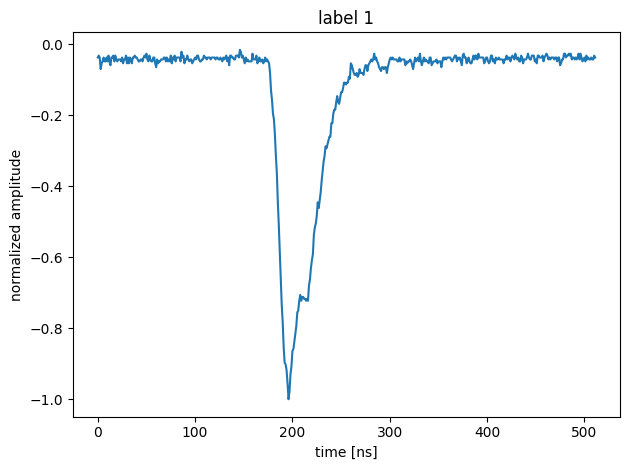

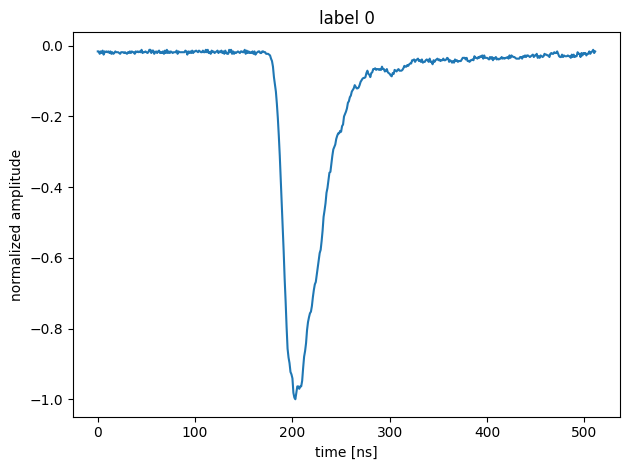

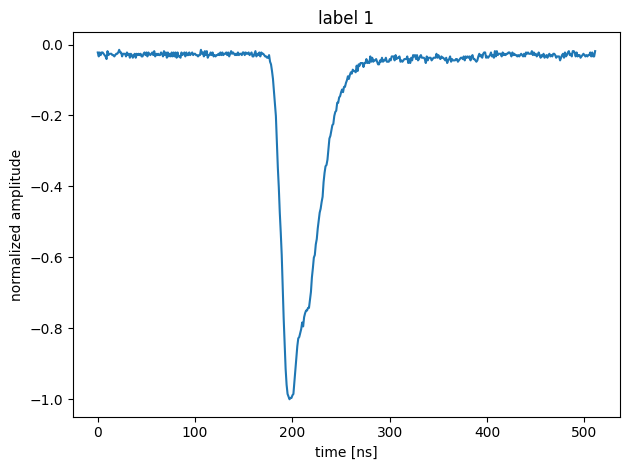

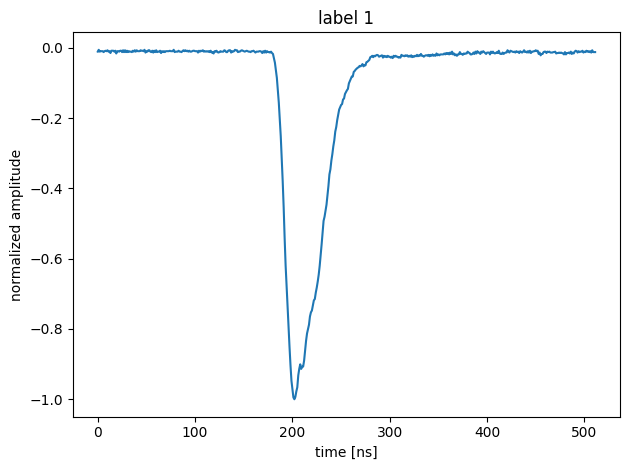

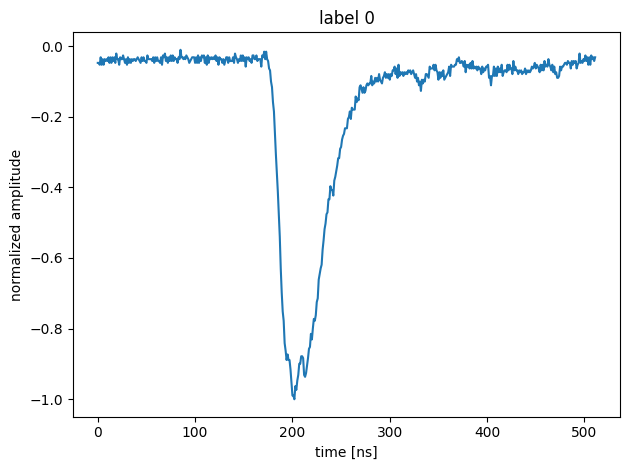

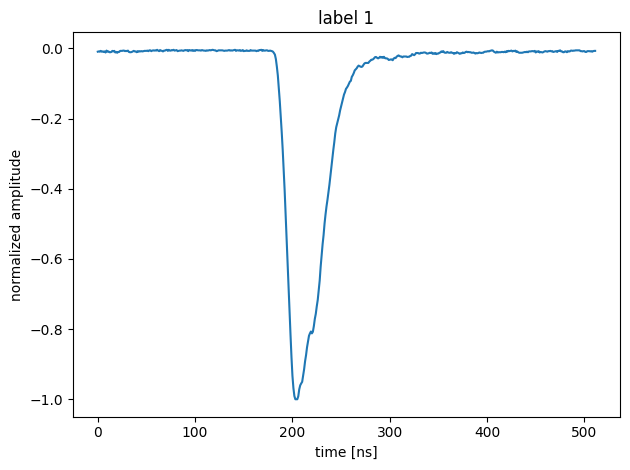

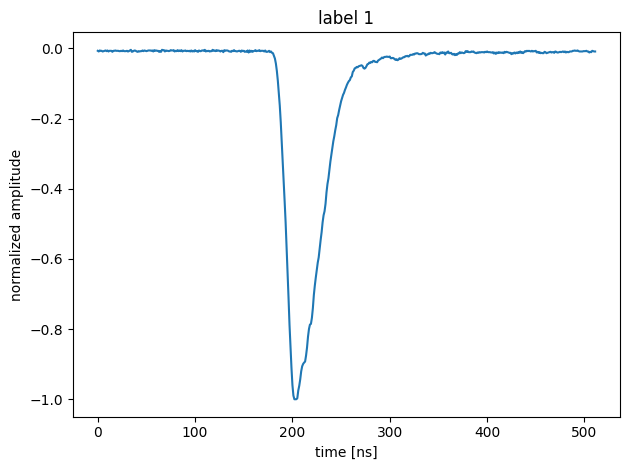

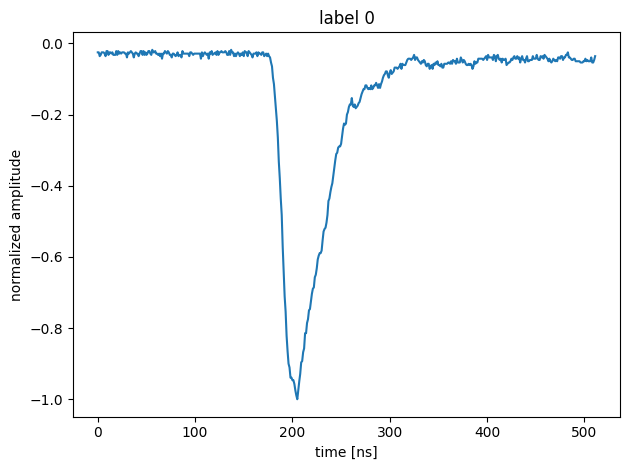

In [7]:
# plot a few events
for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.plot(X_train[i,:,0])
    ax.set_title(f"label {y_train[i]}")
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("normalized amplitude")
    fig.tight_layout()
    plt.show()
    plt.close("all")

In [8]:
import os
path = os.path.join('saved_models')
if not os.path.exists(path):
    os.makedirs(path)

Now we can define the neural network and train it.

In [ ]:
# first the usual imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, Input, Flatten, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle


# model = Sequential()

# if you use a fully connected network (dense) you need to flatten the input data first. You can implement this
# as a network layer:
# model.add(Flatten(input_shape=(samples_per_pulse, 1)))

# if you use a convlutional layer first, you can directly use the input data
# model.add(Conv1D(, , padding=, activation=, input_shape=(samples_per_pulse, 1)))
model_baseline = Sequential([
    Conv1D(16, 5, activation='relu', input_shape=(samples_per_pulse,1)),
    MaxPooling1D(2),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bigger = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(samples_per_pulse,1)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [10]:
# compile
model_baseline.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_bigger.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# trining
history_baseline = model_baseline.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    verbose=0)

history_bigger = model_bigger.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    verbose=0)

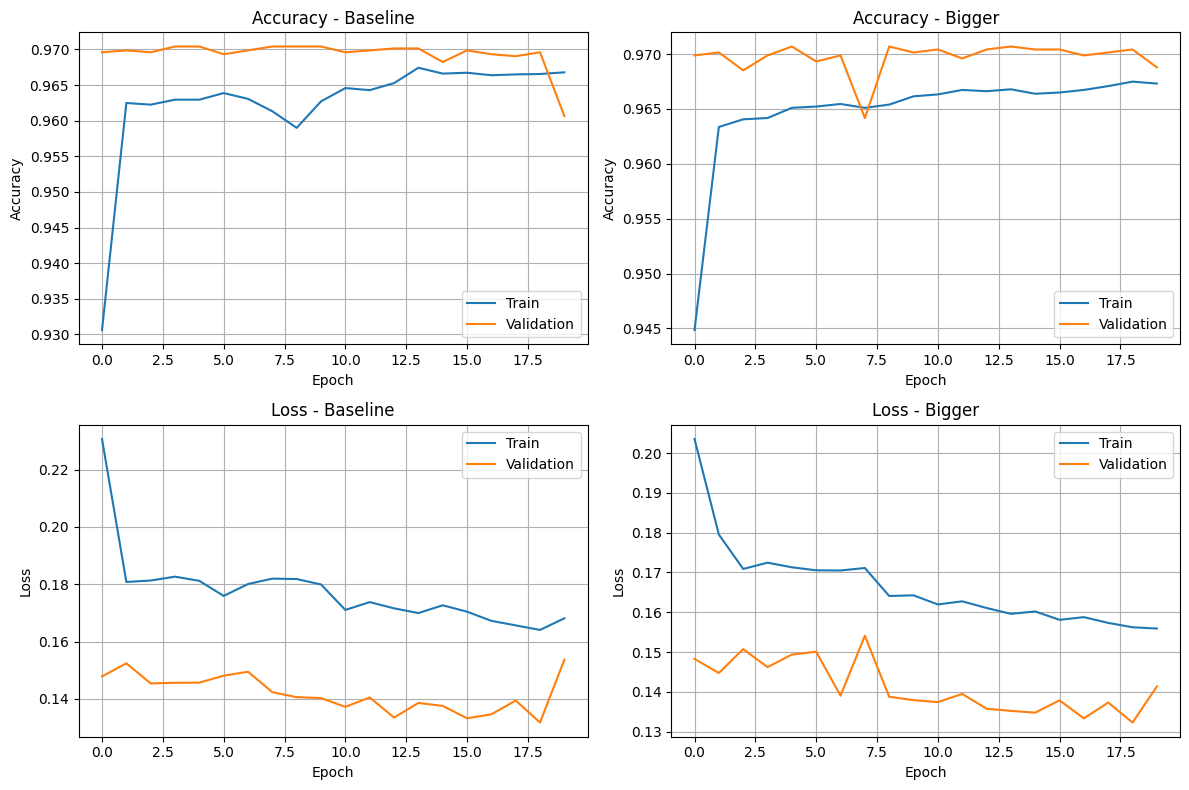

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Accuracy - Baseline
axes[0,0].plot(history_baseline.history['accuracy'], label='Train')
axes[0,0].plot(history_baseline.history['val_accuracy'], label='Validation')
axes[0,0].set_title('Accuracy - Baseline')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Accuracy - Bigger
axes[0,1].plot(history_bigger.history['accuracy'], label='Train')
axes[0,1].plot(history_bigger.history['val_accuracy'], label='Validation')
axes[0,1].set_title('Accuracy - Bigger')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

# Loss - Baseline
axes[1,0].plot(history_baseline.history['loss'], label='Train')
axes[1,0].plot(history_baseline.history['val_loss'], label='Validation')
axes[1,0].set_title('Loss - Baseline')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].grid(True)

# Loss - Bigger
axes[1,1].plot(history_bigger.history['loss'], label='Train')
axes[1,1].plot(history_bigger.history['val_loss'], label='Validation')
axes[1,1].set_title('Loss - Bigger')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


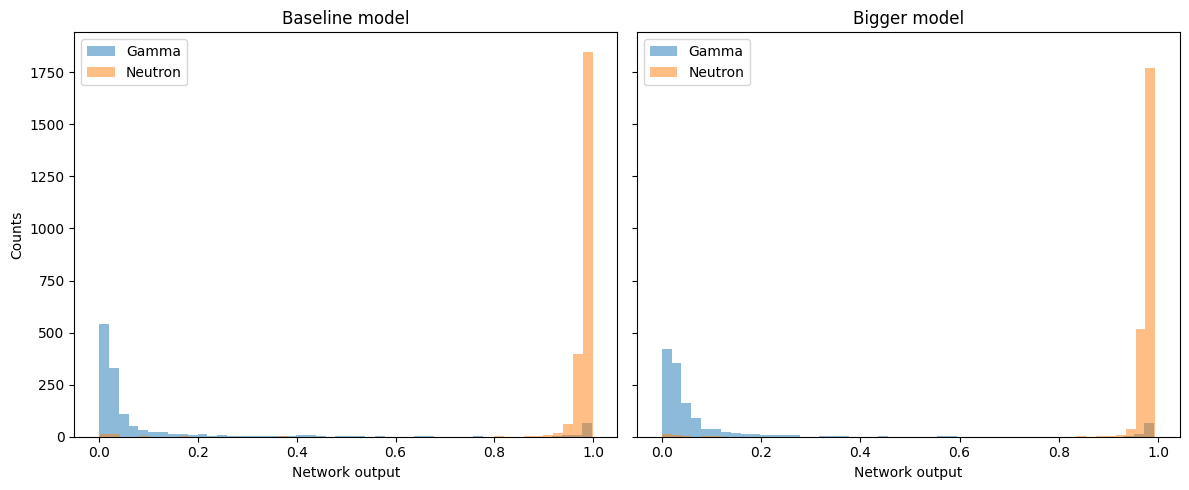

In [ ]:
y_pred_baseline = model_baseline.predict(X_test).flatten()
y_pred_bigger = model_bigger.predict(X_test).flatten()

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Bseline
axes[0].hist(y_pred_baseline[y_test==0], bins=50, alpha=0.5, label='Gamma')
axes[0].hist(y_pred_baseline[y_test==1], bins=50, alpha=0.5, label='Neutron')
axes[0].set_title('Baseline model')
axes[0].set_xlabel('Network output')
axes[0].set_ylabel('Counts')
axes[0].legend()

# Bigger
axes[1].hist(y_pred_bigger[y_test==0], bins=50, alpha=0.5, label='Gamma')
axes[1].hist(y_pred_bigger[y_test==1], bins=50, alpha=0.5, label='Neutron')
axes[1].set_title('Bigger model')
axes[1].set_xlabel('Network output')
axes[1].legend()

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score

y_pred_baseline_class = (y_pred_baseline > 0.5).astype(int)
acc_baseline = accuracy_score(y_test, y_pred_baseline_class)
print("Accuracy baseline:", acc_baseline)

y_pred_bigger_class = (y_pred_bigger > 0.5).astype(int)
acc_bigger = accuracy_score(y_test, y_pred_bigger_class)
print("Accuracy bigger:", acc_bigger)


Accuracy baseline: 0.9617263843648208
Accuracy bigger: 0.9652551574375678


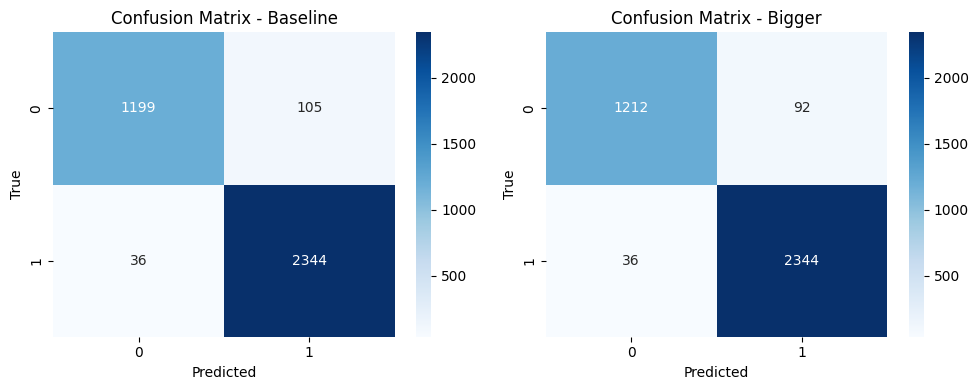

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_baseline_class = (y_pred_baseline > 0.5).astype(int)
y_pred_bigger_class   = (y_pred_bigger > 0.5).astype(int)

cm_baseline = confusion_matrix(y_test, y_pred_baseline_class)
cm_bigger   = confusion_matrix(y_test, y_pred_bigger_class)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Baseline
sns.heatmap(cm_baseline, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Baseline')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Bigger
sns.heatmap(cm_bigger, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - Bigger')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


# Final comments

* The small network (baseline) can separate gammas and neutrons well, with about 96% accuracy and loss around 0.16. The bigger network gives slightly higher accuracy (96.5%) but does not improve much, probably because the baseline is already strong and the dataset is small, it may also start overfitting. Accuracy could be improved by normalizing the input, adjusting the network slightly, or using more training data. The test set accuracy is reliable and the true accuracy is likely very close to the measured value.
